<a href="https://colab.research.google.com/github/Shubhi3199/Tom-N-Jerry-Emotion-Detection/blob/master/Tom_%26_Jerry_Combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Path to saved Mask-RCNN model :
`/content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5`

## Path to saved Emotion-prediction Mobile-netV2-133/244 model:
`/content/drive/My Drive/Tom & Jerry Emotion/models/20200504-001719-final-8100-image-trained-model-mobilenetV2.h5`

In [0]:
!pip install tensorflow==1.5.0
!pip install 'keras==2.1.6' --force-reinstall
!pip3 install scipy==1.1.0 --user

In [0]:
# cd path to Mask_RCNN-2.1 release folder
cd /content/drive/My\ Drive//Mask_RCNN-2.1

/content/drive/My Drive/Mask_RCNN-2.1


In [0]:
import os
import cv2
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


# Root directory of the project
ROOT_DIR = os.getcwd()
print(ROOT_DIR)
if ROOT_DIR.endswith("samples/characters"):
    # Go up two levels to the repo root
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import utils
import visualize
import config
from visualize import display_images
import model as modellib
from model import log

from samples.characters import TomJerry

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to TomJerry trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
CHARACTER_WEIGHTS_PATH = "/content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200417T2109/mask_rcnn_characters_0015.h5"  # TODO: update this path

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarning: Passing (type, 1) or 

/content/drive/My Drive/Mask_RCNN-2.1


Using TensorFlow backend.


In [0]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [0]:
config = TomJerry.CharacterConfig()
CHARACTER_DIR = os.path.join(ROOT_DIR, 'json_data')

In [0]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           characters
NUM_CLASSES                    3
POOL_SIZE                      7
POST_NMS_ROIS_INF

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [0]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [0]:
# Set path to Tom-&-Jerry weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = '/content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5'

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/drive/My Drive/Mask_RCNN-2.1/logs/characters20200421T1905/mask_rcnn_characters_0049.h5


## Use the below cell to extract emotion by a `Video input`

In [0]:
# Enter the name of the video
video_name = 'test_2.mp4'  # update this
videoFilePath = '/content/drive/My Drive/Mask_RCNN-2.1/' + video_name
saveFolder = '/content/drive/My Drive/Mask_RCNN-2.1/test_folder/'

In [0]:
cap = cv2.VideoCapture(videoFilePath)
frameRate = cap.get(5)

i=0
count = 0
while(cap.isOpened()):

  cap.set(cv2.CAP_PROP_POS_FRAMES, count)

  count += math.floor(frameRate)
  print(count)

  ret, frame = cap.read()
  # cv2.imshow('frame',frame)



  if (ret != True) or cv2.waitKey(1) & 0xFF == ord('q') or count>=8912:
    break

  cv2.imwrite(saveFolder+"frame"+str(i)+".jpg",frame)
  i+=1
  # if count % math.floor(frameRate) == 0:




cap.release()
cv2.destroyAllWindows()

## To predict emotion by directly giving one/more `Image input` :

*directly upload the test image(s) in the folder :*


`/content/drive/My Drive/Mask_RCNN-2.1/test_folder/`


In [0]:
global tom_count
global jerry_count 
tom_count = 0
jerry_count = 0

In [0]:
# function to check for image aspect ratio
from PIL import Image

def make_square(im, min_size=256, fill_color=(0, 0, 0, 255)):
    '''
    function to check for image aspect ratio
    Input - im: Image in PIL Image format.
    '''
    x, y = im.size
    min_size = max(x, y)
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [0]:
# Function that returns a dictionary of class_ids as indexes and list of scores for the corresponding class_ids as values
def get_class_id_score_dict(class_ids, scores):

  '''Function that returns a dictionary of class_ids as indexes and list of 
     scores for the corresponding class_ids as values'''

  id_score_tuple_list = []
  for id, score in zip(class_ids, scores):
    id_score_tuple_list.append((id, score))
  
  from collections import defaultdict
  d1=defaultdict(list)
  for k,v in id_score_tuple_list:
    d1[k].append(v)
  d1 = dict(d1)
  return d1

In [0]:
# Classifer Function that returns the mask array of specificly Tom else Jerry else Unknown
def get_specific_mask(bbox, masks,  dictionary, class_ids_arr, image, image_name):

  '''
  Classifer Function that returns the mask array of specificly Tom else Jerry 
  else Unknown.

  Input: 
  masks - Array of all masks returned by detect function in model.py
  dictionary - dict of class_ids and their respective scores

  Returns: 
  Returns Array of either tom's mask if found else jerry's mask and if neither 
  of the above two is passed then returns unknown.
  '''
  path_to_save_face_black = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_test_images/'
  global tom_count
  global jerry_count

  class_ids_array = class_ids_arr

  if 1 in dictionary:
    tom_count += 1
    final_tom_index, = np.where(class_ids_array == 1)
    final_tom_index2 = final_tom_index[0]
    tom_mask =  masks[:,:,final_tom_index2]
    big_frame_tom_mask = get_mask(tom_mask, image)

    [y1, x1, y2, x2] = bbox[final_tom_index2]

    crop_image_black = big_frame_tom_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_face_black +  os.path.splitext(image_name)[0] + '_tom' + '.png', crop_image_black)
    # print(f'Tom cropped face saved! at {tom_count}.png')

  elif 2 in dictionary:
    jerry_count += 1
    final_jerry_index, = np.where(class_ids_array == 2)
    final_jerry_index2 = final_jerry_index[0]
    jerry_mask =  masks[:,:,final_jerry_index2]
    big_frame_jerry_mask = get_mask(jerry_mask, image)

    [y1, x1, y2, x2] = bbox[final_jerry_index2]

    crop_image_black = big_frame_jerry_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_face_black +  os.path.splitext(image_name)[0] + '_jerry' + '.png', crop_image_black)
    # print(f'Jerry cropped face saved! at {jerry_count}.png')

  else:
    
    img = np.zeros((256,256,3), np.uint8)
    cv2.imwrite(path_to_save_face_black + os.path.splitext(image_name)[0] + '_unknown' + '.png', img)

In [0]:
# Function to return masks generated of the same size as that of original image 
def get_mask(specific_mask_array, image):
  '''
  Function to return masks generated of the same size as that of original image
  Input:  specific_mask_array generated by get_specific_mask() function 
  '''
  temp = image
  temp = np.array(temp)
  for j in range(temp.shape[2]):
      temp[:,:,j] = temp[:,:,j] * specific_mask_array
  # plt.figure(figsize=(8,8))
  # print(type(temp))
  # plt.imshow(temp);
  return temp


In [0]:
# Function to load all images and detect tom/jerry get the mask resize it and then finally save the images to generate data for emotion prediction model
def detect_crop_save(root_folder_path):

  '''
  Function to load all images and detect tom/jerry get the mask resize it and 
  then finally save the images to generate data for emotion prediction model
  '''
  # for frame_folder in os.listdir(root_folder_path):
  #   print('\n')
  #   print(f'Extracting images from folder: {frame_folder} \n')
  #   frame_folder_path = os.path.join(root_folder_path, frame_folder)
  #   image_count = 0
    # total_image_count = len(os.listdir(frame_folder_path))
  for image in sorted_alphanumeric(os.listdir(root_folder_path)):
    # image_count += 1
    # print(f'Processing {image_count}/{total_image_count} image!')
    image_path = os.path.join(root_folder_path, image)

    image2 = cv2.imread(image_path)
    image2 = np.array(image2)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    image2.astype(np.float32)
    
    image7, window, scale, padding = utils.resize_image(
          image2,
          min_dim=config.IMAGE_MIN_DIM,
          max_dim=config.IMAGE_MAX_DIM,
          padding=config.IMAGE_PADDING)
    # Detect objects
    # print(image3.shape)
    image7 = np.array(image7)
    r = model.detect([image7])[0]


    dictionary = get_class_id_score_dict(r['class_ids'], r['scores'])
    # print(f'Image Path: {image_path}')
    # print(r['class_ids'])
    # print(dictionary)

    get_specific_mask(r['rois'], r['masks'], dictionary, r['class_ids'], image7, image)
    #bbox, masks,  dictionary, class_ids_arr, image, image_name
    # get_all_bbox_and_save(r['rois'], r['masks'], dictionary, r['class_ids'], image7)
    # get_all_masks_and_save(r['masks'], dictionary, r['class_ids'], image7)

In [0]:
def get_all_bbox_and_save(bbox, masks,  dictionary, class_ids_arr, image):

  '''
  Function that does everything.
  Input: bbox = r['rois'], bbox coordinates,
         masks = r['masks'] masks array,
         dictionary = dict containing info of class with their scores,
         class_ids_arr = [1 2],
         image = Original Image (1024*1024)

   Returns: Saves the Tom/Jerry cropped-resized (264*264) mask in their 
            respected Folders.   
  '''

  path_to_save_tom_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/tom/'
  path_to_save_jerry_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/jerry/'

  path_to_save_tom_face_black = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/tom_black/'
  path_to_save_jerry_face_black = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/jerry_black/'

  global tom_count
  global jerry_count

  class_ids_array = class_ids_arr

  if 1 in dictionary:
    tom_count += 1
    final_tom_index, = np.where(class_ids_array == 1)
    final_tom_index2 = final_tom_index[0]
    tom_mask =  masks[:,:,final_tom_index2]
    big_frame_tom_mask = get_mask(tom_mask, image)

    # [y1, x1, y2, x2] = bbox[0]
    [y1, x1, y2, x2] = bbox[final_tom_index2]

    crop_img = image[y1:y2, x1:x2]

    pil_crop_image = Image.fromarray(crop_img)
    new_image = make_square(pil_crop_image)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    crop_image_black = big_frame_tom_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_tom_face +  str(tom_count) + '.png', crop_img)
    cv2.imwrite(path_to_save_tom_face_black +  str(tom_count) + '.png', crop_image_black)
    print(f'Tom cropped face saved! at {tom_count}.png')

  if 2 in dictionary:
    jerry_count += 1
    final_jerry_index, = np.where(class_ids_array == 2)
    final_jerry_index2 = final_jerry_index[0]
    jerry_mask =  masks[:,:,final_jerry_index2]
    big_frame_jerry_mask = get_mask(jerry_mask, image)

    # [y1, x1, y2, x2] = bbox[0]
    [y1, x1, y2, x2] = bbox[final_jerry_index2]

    crop_img = image[y1:y2, x1:x2]

    pil_crop_image = Image.fromarray(crop_img)
    new_image = make_square(pil_crop_image)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    crop_image_black = big_frame_jerry_mask[y1:y2, x1:x2]

    pil_crop_image_black = Image.fromarray(crop_image_black)
    new_image = make_square(pil_crop_image_black)
    new_image = np.array(new_image)
    resized_image = cv2.resize(new_image, (256, 256), 
                           interpolation=cv2.INTER_NEAREST)
    crop_image_black = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    cv2.imwrite(path_to_save_jerry_face +  str(jerry_count) + '.png', crop_img)
    cv2.imwrite(path_to_save_jerry_face_black +  str(jerry_count) + '.png', crop_image_black)
    print(f'Jerry cropped face saved! at {jerry_count}.png')
  
  print('\n')

In [0]:
# get the masks of both tom and jerry is available and save iy in extracted_images directory for creating dataset for emotion prediction model
def get_all_masks_and_save(masks, dictionary, class_ids_arr, image):
  '''
  get the masks of both tom and jerry is available and save iy in extracted_images
  directory for creating dataset for emotion prediction model
  '''
  path_to_save_tom_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/tom/'
  path_to_save_jerry_face = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_images/jerry/'

  global tom_count
  global jerry_count
  class_ids_array = class_ids_arr
  if 1 in dictionary:
    tom_count += 1
    # Found Tom Mask in the image
    # Get the max score index if more than 1 toms are detected

    # tom_max_score_index = np.array(dictionary[1]).argmax()
    # # final_tom_index = np.array(dictionary[1]).argmax()
    # if 2 in dictionary:
    #   final_tom_index = len(dictionary[2]) + tom_max_score_index
    # else:
    #   final_tom_index = tom_max_score_index  
    final_tom_index, = np.where(class_ids_array == 1)
    # # Generate mask for Tom
    final_tom_index2 = final_tom_index[0]
    tom_mask =  masks[:,:,final_tom_index2]
    # return tom_mask
    big_frame_tom_mask = get_mask(tom_mask, image)
    crop_mask(big_frame_tom_mask, path_to_save_tom_face +  str(tom_count) + '.png')

  if 2 in dictionary:
    jerry_count += 1
    # Found Jerry Mask in the image
    # Get the max score index if more than 1 Jerrys are detected
    # final_jerry_index = np.array(dictionary[2]).argmax()
    final_jerry_index, = np.where(class_ids_array == 2)
    # Generate mask for Jerry
    final_jerry_index2 = final_jerry_index[0]
    jerry_mask =  masks[:,:,final_jerry_index2]
    big_frame_jerry_mask = get_mask(jerry_mask, image)
    crop_mask(big_frame_jerry_mask, path_to_save_jerry_face + str(jerry_count) + '.png')

## Run the below cell to get the segmented face masks (tom prioritised)
*Input Source Folder:* `/content/drive/My Drive/Mask_RCNN-2.1/test_folder`

*Destination save Folder:* `/content/drive/My Drive/Mask_RCNN-2.1/extracted_test_images/` 

In [0]:
 detect_crop_save('/content/drive/My Drive/Mask_RCNN-2.1/test_folder')

# Emotion-Prediction Model

In [0]:
!pip install --upgrade tensorflow
!pip install --upgrade keras==2.3.1
!pip install --upgrade html5lib bleach six PyYAML

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)
     |████████████████████████████████| 3.0MB 3.4MB/s 


Requirement already up-to-date: keras==2.3.1 in /usr/local/lib/python3.6/dist-packages (2.3.1)
Requirement already up-to-date: html5lib in /usr/local/lib/python3.6/dist-packages (1.0.1)
Requirement already up-to-date: bleach in /usr/local/lib/python3.6/dist-packages (3.1.5)
Requirement already up-to-date: six in /usr/local/lib/python3.6/dist-packages (1.14.0)
Requirement already up-to-date: PyYAML in /usr/local/lib/python3.6/dist-packages (5.3.1)


In [0]:
!pip install --upgrade imgaug==0.2.5

In [0]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [0]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0rc3
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, astunparse, tensorflow-estimator, termcolor, six, h5py, opt-einsum, google-pasta, grpcio, wheel, scipy, keras-preprocessing, numpy, wrapt, protobuf, tensorboard, gast
Required-by: fancyimpute


In [0]:
print(tf.__version__)

2.2.0-rc3


## Cells for training the model and Analysing the data 

In [0]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [0]:
all_emotions = ['Happy', 'Sad', 'Angry', 'Surprised']

In [0]:
# Getting image file names from individual tom and jerry folder from their respective emotion folder
jerry_folder_path = '/content/drive/My Drive/Tom & Jerry Emotion/Emotions/Emotions-Dataset.zip (Unzipped Files)/Emotions-Dataset/Jerry'
tom_folder_path = '/content/drive/My Drive/Tom & Jerry Emotion/Emotions/Emotions-Dataset.zip (Unzipped Files)/Emotions-Dataset/Tom'



jerry_sad_image_names = sorted_alphanumeric(os.listdir(os.path.join(jerry_folder_path, 'Sad')))
jerry_sad_image_names = [ os.path.splitext(jerry_sad_image_names)[0] for jerry_sad_image_names in jerry_sad_image_names]

jerry_happy_image_names = sorted_alphanumeric(os.listdir(os.path.join(jerry_folder_path, 'Happy')))
jerry_happy_image_names = [ os.path.splitext(jerry_happy_image_names)[0] for jerry_happy_image_names in jerry_happy_image_names]

jerry_angry_image_names = sorted_alphanumeric(os.listdir(os.path.join(jerry_folder_path, 'Angry')))
jerry_angry_image_names = [ os.path.splitext(jerry_angry_image_names)[0] for jerry_angry_image_names in jerry_angry_image_names]

jerry_surprised_image_names = sorted_alphanumeric(os.listdir(os.path.join(jerry_folder_path, 'Surprised')))
jerry_surprised_image_names = [ os.path.splitext(jerry_surprised_image_names)[0] for jerry_surprised_image_names in jerry_surprised_image_names]

tom_sad_image_names = sorted_alphanumeric(os.listdir(os.path.join(tom_folder_path, 'Sad')))
tom_sad_image_names = [ os.path.splitext(tom_sad_image_names)[0] for tom_sad_image_names in tom_sad_image_names]

tom_happy_image_names = sorted_alphanumeric(os.listdir(os.path.join(tom_folder_path, 'Happy')))
tom_happy_image_names = [ os.path.splitext(tom_happy_image_names)[0] for tom_happy_image_names in tom_happy_image_names]

tom_angry_image_names = sorted_alphanumeric(os.listdir(os.path.join(tom_folder_path, 'Angry')))
tom_angry_image_names = [ os.path.splitext(tom_angry_image_names)[0] for tom_angry_image_names in tom_angry_image_names]

tom_surprised_image_names = sorted_alphanumeric(os.listdir(os.path.join(tom_folder_path, 'Surprised')))
tom_surprised_image_names = [ os.path.splitext(tom_surprised_image_names)[0] for tom_surprised_image_names in tom_surprised_image_names]

In [0]:
all_image_names = jerry_sad_image_names + jerry_happy_image_names + jerry_angry_image_names + jerry_surprised_image_names + tom_sad_image_names + tom_happy_image_names + tom_angry_image_names + tom_surprised_image_names

In [0]:
all_image_names[:10]

['Jerry_Sad_1',
 'Jerry_Sad_2',
 'Jerry_Sad_3',
 'Jerry_Sad_4',
 'Jerry_Sad_5',
 'Jerry_Sad_6',
 'Jerry_Sad_7',
 'Jerry_Sad_8',
 'Jerry_Sad_9',
 'Jerry_Sad_10']

In [0]:
labels_csv_new = pd.DataFrame(columns = ['Frame_ID', 'Emotion'])

labels_csv_new['Frame_ID'] = all_image_names

labels_csv_new['Emotion'][:347] = 'sad_jerry'
labels_csv_new['Emotion'][347:1092] = 'happy_jerry'
labels_csv_new['Emotion'][1092: 1390] = 'angry_jerry'
labels_csv_new['Emotion'][1390: 1916] = 'surprise_jerry'
labels_csv_new['Emotion'][1916: 2350] = 'sad_tom'
labels_csv_new['Emotion'][2350:2802] = 'happy_tom'
labels_csv_new['Emotion'][2802: 3252] = 'angry_tom'
labels_csv_new['Emotion'][3252: ] = 'surprise_tom'

In [0]:
labels_csv_new

,Frame_ID,Emotion
0,Jerry_Sad_1,sad_jerry
1,Jerry_Sad_2,sad_jerry
2,Jerry_Sad_3,sad_jerry
3,Jerry_Sad_4,sad_jerry
4,Jerry_Sad_5,sad_jerry
...,...,...
3709,Tom_Surprised_458,surprise_tom
3710,Tom_Surprised_459,surprise_tom
3711,Tom_Surprised_460,surprise_tom
3712,Tom_Surprised_461,surprise_tom


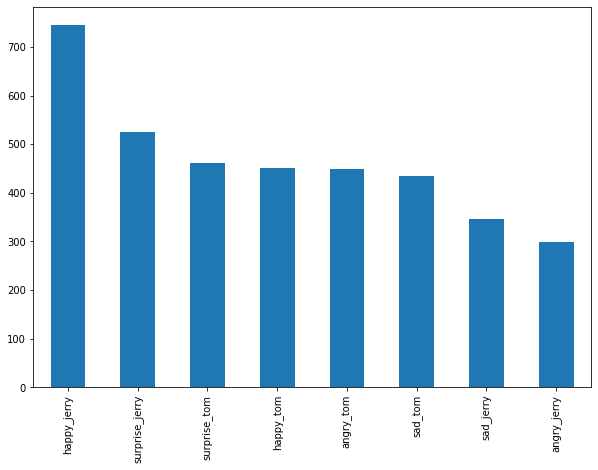

In [0]:
labels_csv_new['Emotion'].value_counts().plot.bar(figsize = (10, 7));

In [0]:
labels_csv_new['Emotion'].value_counts().median(), labels_csv_new['Emotion'].value_counts().sum()

(451.0, 3714)

In [0]:
# Get the list of filenames for our images
image_folder_path = '/content/drive/My Drive/Tom & Jerry Emotion/Emotions/Emotions-Dataset.zip (Unzipped Files)/Emotions-Dataset/'

file_names_jerry_sad = [image_folder_path + 'Jerry/Sad/' + fnames for fnames in labels_csv_new['Frame_ID'][:347] + '.png']
file_names_jerry_happy = [image_folder_path + 'Jerry/Happy/' + fnames for fnames in labels_csv_new['Frame_ID'][347:1092] + '.png']
file_names_jerry_angry = [image_folder_path + 'Jerry/Angry/' + fnames for fnames in labels_csv_new['Frame_ID'][1092: 1390] + '.png']
file_names_jerry_surprise = [image_folder_path + 'Jerry/Surprised/' + fnames for fnames in labels_csv_new['Frame_ID'][1390: 1916] + '.png']
                             
file_names_tom_sad = [image_folder_path + 'Tom/Sad/' + fnames for fnames in labels_csv_new['Frame_ID'][1916: 2350] + '.png']
file_names_tom_happy = [image_folder_path + 'Tom/Happy/' + fnames for fnames in labels_csv_new['Frame_ID'][2350:2802] + '.png']
file_names_tom_angry = [image_folder_path + 'Tom/Angry/' + fnames for fnames in labels_csv_new['Frame_ID'][2802: 3252] + '.png']
file_names_tom_surprise = [image_folder_path + 'Tom/Surprised/' + fnames for fnames in labels_csv_new['Frame_ID'][3252:] + '.png']                            

In [0]:
all_file_names =  file_names_jerry_sad + file_names_jerry_happy + file_names_jerry_angry + file_names_jerry_surprise + file_names_tom_sad + file_names_tom_happy + file_names_tom_angry + file_names_tom_surprise

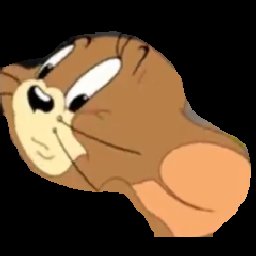

In [0]:
from IPython.display import Image
Image(all_file_names[1])

In [0]:
labels = labels_csv_new['Emotion'].to_numpy()
labels, len(labels)

(array(['sad_jerry', 'sad_jerry', 'sad_jerry', ..., 'surprise_tom',
        'surprise_tom', 'surprise_tom'], dtype=object), 3714)

In [0]:
# Finding the unique_labels out of labels array
unique_labels = np.unique(labels)
unique_labels

array(['angry_jerry', 'angry_tom', 'happy_jerry', 'happy_tom',
       'sad_jerry', 'sad_tom', 'surprise_jerry', 'surprise_tom'],
      dtype=object)

## Cells for gettin the test results

In [0]:
IMG_SIZE = 224
def preprocessor(image_path, image_size = IMG_SIZE):
  '''
  Takes an image file path and turns it into a tensor, normalizes and reshapes it
  '''
  # Read an image file
  image = tf.io.read_file(image_path)

  # Turn the jpg image into a tensor with 3 color channels
  image = tf.image.decode_jpeg(image, channels = 3)

  # Normalization, from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired values (60, 60)
  image = tf.image.resize(image, size = [IMG_SIZE, IMG_SIZE])

  return image

In [0]:
# Create a function to return (image, label)
def get_image_label(image_path, label):
  '''
  Takes image file path and the associated label as the imput and gives out
  the tuple of the two
  '''
  image = preprocessor(image_path)
  return image, label

In [0]:
# Defining the batch size
BATCH_SIZE = 32
# Creating a function to convert data into batches
def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  '''
  Creates batches of Data out of images x and labels y pairs.
  Shuffles the training data but not validation data
  Also accepts test data as input (without labels)
  '''

  if test_data:
    print('Creating Test Data Batches!')

    # Turn filepaths (images) into a list of tensors/slices a big  tensor into smaller objects
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))

    # Preprocess these sliced tensors(tensor for each image in file_names array) & batch them
    data_batch = data.map(preprocessor).batch(BATCH_SIZE)

    return data_batch

  elif valid_data:
    print('Creating Valid Data batches!')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:

    print('Creating Training data batches!')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                              tf.constant(y)))
    # Shuffling pathnames and labels before mapping preprocessor function
    data = data.shuffle(buffer_size = len(x))

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

  return data_batch


In [0]:
# Loading a saved trained model 
def load_model(model_path):
  print(f'Loading a saved model from the path: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {'KerasLayer': hub.KerasLayer})
  return model

In [168]:
loaded_model = load_model('/content/drive/My Drive/Tom & Jerry Emotion/models/20200504-001719-final-8100-image-trained-model-mobilenetV2.h5')

Loading a saved model from the path: /content/drive/My Drive/Tom & Jerry Emotion/models/20200504-001719-final-8100-image-trained-model-mobilenetV2.h5


# MAking Predictions on the test data

* Get the test image filenames
* Convert the filenames into test data batches using create_data_batch()
* Make presictions by passing the test batches to the predict() method called on the full model

In [0]:
test_path = '/content/drive/My Drive/Mask_RCNN-2.1/extracted_test_images/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
sorted_test_filenames = sorted_alphanumeric(test_filenames)


In [182]:
sorted_test_filenames[10]

'/content/drive/My Drive/Mask_RCNN-2.1/extracted_test_images/frame13_tom.png'

In [184]:
len(sorted_test_filenames)

134

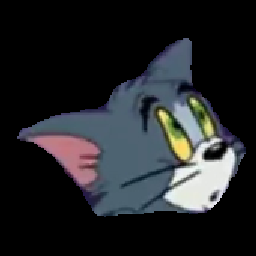

In [183]:
from IPython.display import Image
Image(sorted_test_filenames[17])

In [0]:
# Making Function for test Dataset predictions
def get_test_predictions(test_folder_path):

  test_path = test_folder_path
  test_filenames = [test_path + fname for fname in os.listdir(test_path)]
  sorted_test_filenames = sorted_alphanumeric(test_filenames)

  test_data = create_data_batches(x = sorted_test_filenames, test_data=True)

  test_predictions = loaded_model.predict(test_data)

  return test_data, test_predictions

In [173]:
len(os.listdir(test_path))

134

In [0]:
# Moving the unknown extracted test images to a different folder
unknown_extracted_test_images_folder_path = '/content/drive/My Drive/Mask_RCNN-2.1/unknown_extracted_test_images' 

for file_name in sorted_alphanumeric(os.listdir(test_path)):
  if 'unknown' in file_name:
    unknown_image_source_path = os.path.join(test_path, file_name)
    unknown_image_dest_path = os.path.join(unknown_extracted_test_images_folder_path, file_name)

    os.replace(unknown_image_source_path, unknown_image_dest_path)


In [187]:
# Calling the get_test_predictions and prepare_dataframe functions on the segmented test data
# test_batched_data, test_segmented_predictions = get_test_predictions(test_folder_path = test_path)
test_batched_data, test_segmented_predictions = get_test_predictions(test_folder_path = test_path)

Creating Test Data Batches!


In [0]:
type(test_batched_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [0]:
unique_labels = ['angry_jerry', 'angry_tom', 'happy_jerry', 'happy_tom',
       'sad_jerry', 'sad_tom', 'surprise_jerry', 'surprise_tom']
unique_labels = np.array(unique_labels)   

In [189]:
test_segmented_predictions[:10], test_segmented_predictions.shape

(array([[5.05155349e-08, 8.35611671e-03, 9.04338322e-06, 1.99582711e-01,
         8.56443023e-08, 1.50990084e-01, 2.44489726e-08, 6.41061902e-01],
        [3.99849798e-09, 1.56471562e-02, 2.09297627e-06, 3.94769944e-02,
         3.75361282e-07, 3.25864330e-02, 1.16079448e-08, 9.12286818e-01],
        [1.17060473e-07, 2.07255676e-01, 2.16138609e-08, 2.57283803e-02,
         1.77578625e-06, 7.35784411e-01, 1.37411735e-08, 3.12296320e-02],
        [9.87577806e-08, 8.44837353e-03, 2.43317277e-09, 4.68720449e-03,
         1.28335239e-06, 6.88316762e-01, 3.36061357e-09, 2.98546255e-01],
        [3.37431558e-08, 2.96078343e-02, 4.91527530e-09, 8.51670559e-03,
         2.49400568e-06, 8.74322891e-01, 4.67236916e-08, 8.75498503e-02],
        [6.68077837e-06, 1.74022361e-03, 5.45362582e-07, 5.48837008e-03,
         9.21488099e-05, 8.69855464e-01, 2.83693971e-05, 1.22788131e-01],
        [1.09127332e-10, 8.73142481e-02, 1.60674816e-07, 2.04041794e-01,
         1.29130342e-07, 1.76305622e-01, 2.75

In [190]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  pred_indv_emotion = unique_labels[np.argmax(prediction_probabilities)]
  if 'happy' in pred_indv_emotion:
    return 'happy'
  elif 'angry' in pred_indv_emotion:
    return 'angry'
  else:
    return 'surprise'

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(test_segmented_predictions[17])
pred_label

'surprise'

In [191]:
# get the predicted label for all the images
for i in range(10):
  pred_label = get_pred_label(test_segmented_predictions[i])
  print(pred_label)

surprise
surprise
surprise
surprise
surprise
surprise
surprise
angry
happy
surprise


In [0]:
#  Create a function to unbatch test data (i.e. only images are unbatched)

def unbatchify_test_data(data):
  '''function to unbatch test data (i.e. only images are unbatched)'''
  images = []
  for image in data.unbatch().as_numpy_iterator():
    images.append(image)
  return images


In [0]:
def visualize_test_predictions(prediction_prob_array, images, n = 1):

  pred_probability, image = prediction_prob_array[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_probability)

  # plot the image
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the title to - predicted label, probability of predection, and truth label
  plt.title('{} {:2.0f}% '.format(pred_label, 
                                     np.max(pred_probability)*100),
                                      color = 'red')
                                     


In [0]:
# unbatchify test data into images and labels for visualization
test_images = unbatchify_test_data(data = test_batched_data)

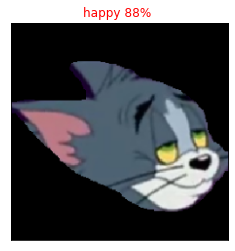

In [196]:
# Visualizing the test data predictions

visualize_test_predictions(prediction_prob_array = test_segmented_predictions, 
                           images = test_images, n = 8)

# Preparing test dataframe for HackerEarth Submission

In [0]:
unknown_test_path = '/content/drive/My Drive/Mask_RCNN-2.1/unknown_extracted_test_images'
unknown_images_sorted_array = sorted_alphanumeric(os.listdir(unknown_test_path))

In [0]:
def get_Frame_ID_column(test_predictions, test_path, unknown_test_path):
  preds_test_df = pd.DataFrame(columns = ['Frame_ID', 'Emotion'])

  ordered_ID = sorted_alphanumeric([fname for fname in os.listdir(test_path)])
  preds_test_df['Frame_ID'] = ordered_ID
  preds_test_df['Emotion'] = [get_pred_label(emotion) for emotion in test_predictions]

  preds_test_df_2 = pd.DataFrame(columns = ['Frame_ID', 'Emotion'])
  ordered_unknown_ID = sorted_alphanumeric([fname for fname in os.listdir(unknown_test_path)])
  preds_test_df_2['Frame_ID'] =  ordered_unknown_ID
  preds_test_df_2['Emotion'] = 'Unknown'

  appended_preds_test_df = preds_test_df.append(preds_test_df_2)
  appended_preds_test_df_array = appended_preds_test_df.to_numpy()

  Frame_ID_series = []
  Emotion_series = []
  for row in appended_preds_test_df_array:  
    Frame_ID_series.append(row[0])
    Emotion_series.append(row[1])
  return Frame_ID_series

In [0]:
Frame_ID_series = prepare_unsorted_dataframe(test_predictions = test_segmented_predictions, test_path = test_path, unknown_test_path = unknown_test_path)

In [0]:
# best part till now
def prepare_dataframe(test_predictions, test_path, unknown_test_path, frame_names):

  preds_test_df = pd.DataFrame(columns = ['Frame_ID', 'Emotion'])

  ordered_ID = sorted_alphanumeric([fname for fname in os.listdir(test_path)])
  preds_test_df['Frame_ID'] = ordered_ID
  preds_test_df['Emotion'] = [get_pred_label(emotion) for emotion in test_predictions]

  preds_test_df_2 = pd.DataFrame(columns = ['Frame_ID', 'Emotion'])
  ordered_unknown_ID = sorted_alphanumeric([fname for fname in os.listdir(unknown_test_path)])
  preds_test_df_2['Frame_ID'] =  ordered_unknown_ID
  preds_test_df_2['Emotion'] = 'Unknown'

  appended_preds_test_df = preds_test_df.append(preds_test_df_2)
  appended_preds_test_df.index = Frame_ID_series
  appended_preds_test_df.drop(['Frame_ID'], axis = 1, inplace = True)

  a = appended_preds_test_df.index.tolist()
  b = {}
  for x in a:
    i = (x).split('_')[0].split('e')[1]
    b[x] = int(i)

  c = sorted(a, key=lambda x: b[x])
  appended_preds_test_df = appended_preds_test_df.reindex(c)
  appended_preds_test_df['Frame_ID'] = appended_preds_test_df.index
  appended_preds_test_df.index = range(187)
  appended_preds_test_df_reorder=appended_preds_test_df.reindex(columns=['Frame_ID', 'Emotion'])
    
  return appended_preds_test_df_reorder


In [201]:
preds_test_df = prepare_dataframe(test_predictions = test_segmented_predictions, test_path = test_path, unknown_test_path = unknown_test_path, frame_names = Frame_ID_series)
preds_test_df[:11]

,Frame_ID,Emotion
0,frame0_tom.png,surprise
1,frame1_tom.png,surprise
2,frame2_tom.png,surprise
3,frame3_tom.png,surprise
4,frame4_tom.png,surprise
5,frame5_tom.png,surprise
6,frame6_tom.png,surprise
7,frame7_unknown.png,Unknown
8,frame8_unknown.png,Unknown
9,frame9_unknown.png,Unknown


In [0]:
# Saving the segmented test predictions
preds_test_df.to_csv('/content/drive/My Drive/Tom & Jerry Emotion/test_submission_df/test_images_8100_data_combined_file_mobilenetv2.csv',
                     index = False)

In [0]:
# Get the right name of the series item for submission in correct Format
def change_df_series_items_name(df_series):
  ''' Changes the dataframe series name frame59.jpg to test59.jpg'''
  changed_arr = []
  arr = df_series.to_numpy()
  for item in arr:
    string = item.split('.')[0][0:5] 
    list1 = list(string)
    list1 = 'test'
    string = ''.join(list1)

    count = item.split('.')[0][5:]
    string2 = string + count + '.jpg'

    changed_arr.append(string2)

  return changed_arr
